# Assignment 1 - Code Example - Part B

This achieves an accuracy of 93.26% on test set.

In [1]:
# provide some basic operators like matrix multiplication
import cupy as cp

# torch and torchvision provide some very handy utilities for dataset loading
from torch.utils.data import DataLoader
import torchvision.datasets as tv_datasets
import torchvision.transforms as tv_transforms

## Some Useful Classes

In [2]:
# base class
class Module:
    def __init__(self):
        self.training = True

    @property
    def params(self): # trainable parameters
        return []

    def __call__(self, *args, **kwargs):
        return self.forward( *args, **kwargs)
    
    def train(self):
        self.training = True
        

    def eval(self):
        self.training = False


# sequential module
class Sequential(Module, list):
    def __init__(self, *module_lst):
        super().__init__()
        self.modules = list(module_lst)

    @property
    def params(self):
        return sum([m.params for m in self], []) # concat all params

    def train(self):
        self.training = True
        for module in self.modules:
            module.train()  

    def eval(self):
        self.training = False
        for module in self.modules:
            module.eval()  

    def forward(self, x):
        y = x
        for module in self.modules:
            y = module(y)
        return y

    def backward(self, dy):
        dx = dy
        for module in self.modules[::-1]:
            dx = module.backward(dx)
        return dx

## Activative function: Softplus, Sigmoid, LeakyReLU, SELU

This implements the [Softplus](https://pytorch.org/docs/stable/generated/torch.nn.Softplus.html) function.

$y = \frac{1}{\beta} \ln(1+e^{\beta x})$

$y' = \frac{1}{1+e^{-\beta x}}$

Default: $\beta=1$

$e^{\beta x}$ might be too large and unstable; so we use linear function to approximate it when $\beta x$ is above the threshold $20$.

In [3]:
class Softplus(Module):
    def __init__(self, beta=1.0, threshold=20.0):
        assert beta > 0 and threshold > 0
        self.beta = beta
        self.threshold = threshold

    def forward(self, x):
        self.beta_x = self.beta * x # save the input for backward use
        y = cp.log(1 + cp.exp(self.beta_x)) / self.beta
        y_relu = cp.where(x > 0, x, 0)
        return cp.where(x < self.threshold, y, y_relu)

    def backward(self, dy):
        grad = 1 / (1 + cp.exp(-self.beta_x))
        grad_relu = cp.where(self.beta_x > 0, 1, 0)
        return dy * cp.where(self.beta_x < self.threshold, grad, grad_relu)

In [4]:
class Sigmoid(Module):
    def forward(self, x):
        self.y = 1/ (1 + cp.exp(-x))
        return self.y

    def backward(self, dy):
        return dy * self.y * (1-self.y)

class LeakyReLU(Module):
    def __init__(self, neg_slope = 1e-2): ## neg_slope=0 equivalent to ReLU
        self.neg_slope = neg_slope

    def forward(self, x):
        self.x = x
        y = cp.where(x > 0, x, self.neg_slope * x)
        return y

    def backward(self, dy):
        return dy * cp.where(self.x>0, 1, self.neg_slope)

class SELU(Module):
    def __init__(self):
        self.alpha = 1.6732632423543772848170429916717
        self.scale = 1.0507009873554804934193349852946

    def forward(self,x):
        self.x = x
        return self.scale * cp.where(x>0, x, self.alpha * (cp.exp(x)-1))

    def backward(self,dy):
        return dy * self.scale * cp.where(self.x > 0, 1, self.alpha * cp.exp(self.x))

## LinearNoBias & Linear, Conv2d

This implements the [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer but without the bias term.

$y = x W^T$

$dy/dx = W$

$dy/dW = x$

In [5]:
class LinearNoBias(Module):
    def __init__(self, in_features, out_features):
        self.weight = (cp.random.rand(out_features, in_features) * 2 - 1) / in_features ** 0.5
        self.weight_grad = cp.zeros_like(self.weight)

    @property
    def params(self):
        return [dict(val=self.weight, grad=self.weight_grad)]

    def forward(self, x):
        self.x = x
        # print(f"x.shape: {x.shape}, self.weight: {self.weight.shape}")
        return x @ self.weight.T

    def backward(self, dy):
        self.weight_grad[:] = dy.T @ self.x
        return dy @ self.weight


In [6]:
class Linear(Module):  ## y = xWT + b
    def __init__(self, in_features, out_features, bias = True):
        self.weight = (cp.random.rand(out_features, in_features) * 2 - 1) / in_features ** 0.5
        self.w_grad = cp.zeros_like(self.weight)
        self.bias = cp.random.randn(out_features) if bias else None
        self.b_grad = cp.zeros_like(self.bias) if bias else None

    @property
    def params(self):
        para = [dict(val=self.weight, grad=self.w_grad)]
        if self.bias is not None:
            para.append(dict(val=self.bias, grad=self.b_grad))
        return para

    def forward(self, x):
        self.x = x
        # print(f"Linear: x.shape: {x.shape}, self.weight: {self.weight.shape}")
        y = x @ self.weight.T + (self.bias if self.bias is not None else 0)
        return y

    def backward(self, dy):
        self.w_grad[:] = dy.T @ self.x
        if self.bias is not None:
            self.b_grad[:] = cp.sum(dy, axis=0)
        return dy @ self.weight

In [ ]:
class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride = 1, padding = 0, bias = True):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.weight = cp.random.randn(out_channels, in_channels, kernel_size, kernel_size) / cp.sqrt(in_channels*kernel_size*kernel_size)
        self.w_grad = cp.zeros_like(self.weight)
        self.bias = cp.zeros(out_channels) if bias else None
        self.b_grad = cp.zeros_like(self.bias) if bias else None

    @property
    def params(self):
        para = [dict(val=self.weight, grad=self.w_grad)]
        if self.bias is not None:
            para.append(dict(val=self.bias, grad=self.b_grad))
        return para

    def forward(self, x):
        ## add padding to fully recover my net setting ：padding=1
        # print(f"conv2d: x.shape:{x.shape}.", end = "   ")
        if self.padding > 0:
            padding = ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding))
            x = cp.pad(x, padding, mode='constant')
        #   self.x = cp.pad(x, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')
        self.x = x
        # print(f" after padding:x.shape:{self.x.shape}.", end = "   ")
        N_in, C_in, H_in, W_in = self.x.shape

        H_out = (H_in - self.kernel_size)//self.stride + 1
        W_out = (W_in - self.kernel_size)//self.stride + 1

        y = cp.zeros((N_in, self.out_channels, H_out, W_out))

        for n in range(N_in):
            for oc in range(self.out_channels):
                for h in range(H_out):
                    for w in range(W_out):
                        from_h = h * self.stride
                        from_w = w * self.stride
                        y[n,oc,h,w] = cp.sum(self.x[n,:, from_h:from_h+self.kernel_size, from_w:from_w+self.kernel_size] * self.weight[oc])     ## compute conv window iteratively
                        if self.bias is not None:
                            y[n,oc,h,w] += self.bias[oc]
        # print(f"y.shape: {y.shape}")
        return y

    def backward(self, dy):
        N, C, H, W =  dy.shape
        N_in, C_in, H_in, W_in = self.x.shape
        x_grad = cp.zeros_like(self.x)

        for n in range(N):
            for oc in range(C):
                for h in range(H):
                    for w in range(W):
                        from_h = h * self.stride
                        from_w = w * self.stride
                        self.w_grad[oc] += self.x[n,:,from_h:from_h+self.kernel_size, from_w:from_w+self.kernel_size] * dy[n,oc,h,w]
                        if self.bias is not None:
                            self.b_grad[oc] += dy[n,oc,h,w]
                        x_grad[n,:,from_h:from_h+self.kernel_size, from_w:from_w+self.kernel_size] += self.weight[oc]*dy[n,oc,h,w]

        if self.padding >0:
            x_grad = x_grad[:, :, self.padding:-self.padding, self.padding:-self.padding]

        return x_grad


## Dropout, Batchnorm1d & Batchnorm2d
different when training and evaluation

In [ ]:
class Dropout(Module):
    def __init__(self, p = 0.5):
        self.p = p
        self.training = True

    def forward(self, x):
        if self.training:
            self.var = cp.random.binomial(1, 1-self.p, size = x.shape)
            return x * self. var / (1-self.p)
        else:
            return x
        

    def backward(self, dy):
        if self.training:
            return dy * self.var / (1-self.p)
        else:
            return dy

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

## similar to batchnorm2d
class BatchNorm1d(Module):
    def __init__(self, num_features):
        self.num_features = num_features
        self.eps = 1e-5
        self.momentum = 0.1

        self.gamma = cp.ones(num_features)
        self.gamma_grad = cp.zeros_like(self.gamma)
        self.beta = cp.zeros(num_features)
        self.beta_grad = cp.zeros_like(self.beta)

        self.running_mean = cp.zeros(num_features)
        self.running_var = cp.ones(num_features)

        self.training = True

    @property
    def params(self):
        return [dict(val=self.gamma, grad=self.gamma_grad), dict(val=self.beta, grad=self.beta_grad)]

    def forward(self, x):
        self.x = x
        if self.training:
            self.mean = x.mean(axis=0)
            self.var = x.var(axis=0)
            self.running_mean = self.momentum * self.mean + (1 - self.momentum) * self.running_mean
            self.running_var = self.momentum * self.var + (1 - self.momentum) * self.running_var
            self.x_hat = (x - self.mean) / cp.sqrt(self.var + self.eps)
            return self.gamma * self.x_hat + self.beta

        else:
            self.x_hat = (x - self.running_mean) / cp.sqrt(self.running_var + self.eps)
            return self.gamma * self.x_hat + self.beta

    def backward(self, dy):
        if self.training:
            N = dy.shape[0]
            self.gamma_grad[:] = cp.sum(dy * self.x_hat, axis=0)
            self.beta_grad[:] = cp.sum(dy, axis=0)

            dnorm = dy * self.gamma
            dvar = cp.sum(dnorm * (self.x-self.mean) * -0.5 * (self.var + self.eps) ** (-1.5), axis=0)
            dmean = cp.sum(dnorm * -1 / cp.sqrt(self.var + self.eps), axis=0) + dvar * cp.mean(-2 * (self.x-self.mean), axis=0)

            dx = dnorm / cp.sqrt(self.var + self.eps) + dvar * 2 * (self.x-self.mean) / N + dmean / N

            return dx
        else:
            return dy * self.gamma / cp.sqrt(self.running_var + self.eps)

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

class BatchNorm2d(Module):
    def __init__(self, num_features):
        self.eps = 1e-5
        self.momentum = 0.1

        self.gamma = cp.ones(num_features)
        self.gamma_grad = cp.zeros_like(self.gamma)
        self.beta = cp.zeros(num_features)
        self.beta_grad = cp.zeros_like(self.beta)

        self.running_mean = cp.zeros(num_features)
        self.running_var = cp.ones(num_features)

        self.training = True

    @property
    def params(self):
        return [dict(val=self.gamma, grad=self.gamma_grad), dict(val=self.beta, grad=self.beta_grad)]

    def forward(self, x):
        self.x = x
        # print(f"batchnorm2d x.shape:{x.shape}", end="  ")
        if self.training:
            self.mean = cp.mean(x, axis=(0,2,3), keepdims = True)
            self.var = cp.var(x, axis=(0,2,3), keepdims = True)
            self.x_hat = (x-self.mean)/cp.sqrt(self.var+self.eps)
            y = self.gamma[None, :, None, None] * self.x_hat + self.beta[None, :, None, None]
            self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * self.mean
            self.running_var = (1-self.momentum) * self.running_var + self.momentum * self.var
            # print(f"y.shape:{y.shape}")
            return y
        else:
            self.x_hat = (x - self.running_mean) / cp.sqrt(self.running_var + self.eps)
            y = self.gamma[None, :, None, None] * self.x_hat + self.beta[None, :, None, None]
            return y

    def backward(self, dy):
        N, C, H, W = dy.shape
        if self.training:
            self.gamma_grad[:] = cp.sum(dy * self.x_hat, axis=(0,2,3))
            self.beta_grad[:] = cp.sum(dy, axis=(0,2,3))

            dx_hat = dy * self.gamma[None, :, None, None]
            dvar = cp.sum(dx_hat * (self.x-self.mean) / (-2) * (self.var + self.eps)**(-1.5), axis=(0,2,3), keepdims = True)
            dmean = cp.sum(dx_hat / (-cp.sqrt(self.var + self.eps)), axis=(0,2,3), keepdims = True) + dvar * cp.mean(-2 * (self.x-self.mean), axis=(0,2,3), keepdims = True)
            dx = dx_hat / cp.sqrt(self.var + self.eps) + dvar * 2 * (self.x-self.mean) / (N*H*W) + dmean / (N*H*W)
            return dx
        else:
            dx = dy * self.gamma[None, :, None, None] / cp.sqrt(self.running_var + self.eps)
            return dx

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

## MaxPool2d, Flatten

In [9]:
class MaxPool2d(Module):
    def __init__(self, kernel_size, stride=None):
        self.kernel_size = kernel_size
        self.stride = stride if stride else kernel_size

    def forward(self, x):
        self.x = x
        N, C, H, W = x.shape
        H_out = (H - self.kernel_size) // self.stride + 1
        W_out = (W - self.kernel_size) // self.stride + 1

        y = cp.zeros((N, C, H_out, W_out))
        self.max_indices = cp.zeros_like(x, dtype=bool)

        for n in range(N):
            for c in range(C):
                for h in range(H_out):
                    for w in range(W_out):
                        from_h, from_w = h * self.stride, w * self.stride
                        region = x[n, c, from_h : from_h+self.kernel_size, from_w : from_w+self.kernel_size]

                        max_val = cp.max(region)
                        y[n, c, h, w] = max_val

                        flag = (region == max_val)
                        self.max_indices[n, c, from_h : from_h+self.kernel_size, from_w : from_w+self.kernel_size] = cp.maximum(self.max_indices[n, c, from_h : from_h+self.kernel_size, from_w : from_w+self.kernel_size], flag)
        # print(f"maxpool2d x.shape:{x.shape},y.shape:{y.shape}")
        return y

    def backward(self, dy):
        dx = cp.zeros_like(self.x)
        N, C, H, W = dy.shape

        for n in range(N):
            for c in range(C):
                for h in range(H):
                    for w in range(W):
                        from_h, from_w = h * self.stride, w * self.stride

                        dx[n, c, from_h : from_h+self.kernel_size, from_w : from_w+self.kernel_size] += self.max_indices[n, c, from_h : from_h+self.kernel_size, from_w : from_w+self.kernel_size] * dy[n, c, h, w]

        return dx


In [ ]:
class Flatten(Module):
    def forward(self, x):      ## (n,c,h,w)-->(n,c*h*w)
        self.input_shape = x.shape
        y = x.reshape(x.shape[0], -1)
        # print(f"flatten:x.shape{x.shape},y.shape{y.shape}")
        return y

    def backward(self, dy):
        return dy.reshape(self.input_shape)

## CrossEntropyLoss and  FocalLoss

This implements the [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) loss.


In [ ]:
def onehot(x, num_classes=10):
    y = cp.zeros([len(x), num_classes])
    y[cp.arange(len(x)), x] = 1
    return y


class CrossEntropyLoss(Module):
    def forward(self, x_logit, x_target):
        self.x_logit = x_logit
        self.x_target = x_target

        # softmax
        x_logit_sub = cp.exp(x_logit - cp.max(x_logit, axis=1, keepdims=True))
        x_softmax = x_logit_sub / cp.sum(x_logit_sub, axis=1, keepdims=True)
        x_softmax = cp.clip(x_softmax, a_min=1e-15, a_max=None) # to avoid zero values
        self.x_softmax = x_softmax # save for backward

        # loss of each item
        loss_x = -cp.log(x_softmax)[cp.arange(len(x_target)), x_target]

        # average
        return loss_x.mean()

    def backward(self, dy):
        return dy * (self.x_softmax - onehot(self.x_target)) / len(self.x_logit)

class FocalLoss(Module): ## little modification to cross-entropy loss
    def __init__(self, alpha = 0.25, gamma = 2):
        self.alpha = alpha
        self.gamma = gamma

    def forward(self,x_logit, x_target):
        self.x_logit = x_logit
        self.x_target = x_target

        x_logit_sub = cp.exp(x_logit - cp.max(x_logit, axis=1, keepdims=True))
        x_softmax = x_logit_sub / cp.sum(x_logit_sub, axis=1, keepdims=True)
        x_softmax = cp.clip(x_softmax, a_min=1e-15, a_max=None) 
        self.x_softmax = x_softmax

        pt = x_softmax[cp.arange(len(x_target)), x_target]
        loss_x = -self.alpha * (1-pt) ** (self.gamma) * cp.log(pt)

        return loss_x.mean()

    def backward(self, dy):
        pt = self.x_softmax[cp.arange(len(self.x_target)), self.x_target].reshape(-1, 1)
        dpt = self.alpha * (1-pt)**self.gamma * (self.gamma * cp.log(pt)/(1-pt) - 1/pt)
        grad = dpt * (self.x_softmax - onehot(self.x_target))
        return dy * grad / len(self.x_softmax)




## Optimizer

In [12]:
class Optim:
    def __init__(self, params, lr=0.01):
        self.params = params
        self.lr = lr

    def zero_grad(self):
        for idx in range(len(self.params)):
            self.params[idx]["grad"][:] = 0.0

In [13]:
class SGD(Optim):
    def __init__(self, params, lr=1e-3, momentum = 0):
        super().__init__(params, lr)
        self.momentum = momentum
        self.v = [cp.zeros_like(p["val"]) for p in self.params]

    def step(self):
        for idx in range(len(self.params)):
            self.v[idx] = self.momentum * self.v[idx] - self.lr * self.params[idx]["grad"]
            self.params[idx]["val"] += self.v[idx]

class Adam(Optim):
    def __init__(self, params, lr = 1e-3, weight_decay = 0):
        super().__init__(params, lr)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.eps = 1e-8
        self.weight_decay = weight_decay  # align with my setting in part A
        self.m = [cp.zeros_like(p["val"]) for p in self.params]
        self.v = [cp.zeros_like(p["val"]) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        for idx in range(len(self.params)):
            if self.weight_decay != 0:
                self.params[idx]["grad"] += self.weight_decay * self.params[idx]["val"]
            self.m[idx] = self.beta1 * self.m[idx] + (1-self.beta1) * self.params[idx]["grad"]
            self.v[idx] = self.beta2 * self.v[idx] + (1-self.beta2) * self.params[idx]["grad"] **2

            m_hat = self.m[idx] / (1 - self.beta1 ** self.t)
            v_hat = self.v[idx] / (1 - self.beta2 ** self.t)

            self.params[idx]["val"] -= self.lr * m_hat / (cp.sqrt(v_hat) + self.eps)




## Your Network

In [ ]:
# net = Sequential(
#     LinearNoBias(784, 512), Softplus(),
#     LinearNoBias(512, 256), Softplus(),
#     LinearNoBias(256, 128), Softplus(),
#     LinearNoBias(128, 10),
# )

# try
# net = Sequential(
#               Conv2d(1, 128, 3, padding=1), BatchNorm2d(128), LeakyReLU(0), MaxPool2d(2), Dropout(0.3),
#               Flatten(),
#               # Linear(128 * 14 * 14, 128), BatchNorm1d(128), LeakyReLU(0), Dropout(0.5),
#               Linear(128*14*14, 10)
#         )

net = Sequential(
              Conv2d(1, 128, 3, padding=1), BatchNorm2d(128), LeakyReLU(0), MaxPool2d(2), Dropout(0.3),
              Conv2d(128, 256, 3, padding=1), BatchNorm2d(256), LeakyReLU(0), MaxPool2d(2), Dropout(0.3),
              Conv2d(256, 512, 3, padding=1), BatchNorm2d(512), LeakyReLU(0),
              Conv2d(512, 512, 3, padding=1), BatchNorm2d(512), LeakyReLU(0), MaxPool2d(2), Dropout(0.4),
            
              Flatten(),

              Linear(512 * 3 * 3, 512), BatchNorm1d(512), LeakyReLU(0), Dropout(0.5),
              Linear(512, 256), BatchNorm1d(256), LeakyReLU(0), Dropout(0.5),
              Linear(256, 10)
        )

loss_fn = CrossEntropyLoss()

## Training

In [15]:
# some experimental setup
num_epochs = 2
batch_size = 32  #128
num_workers = 2
print_every = 300

# prepare datasets
dataset, loader = {}, {}
for data_type in ("train", "test"):
    is_train = data_type=="train"
    dataset[data_type] = tv_datasets.MNIST(
        root="./data", train=is_train, download=True,
        transform=tv_transforms.Compose([ # preprocessing pipeline for input images
            tv_transforms.ToTensor(),
            tv_transforms.Normalize((0.1307,), (0.3081,)),
    ]))
    loader[data_type] = DataLoader(
        dataset[data_type], batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
    )


In [ ]:
optimizer = SGD(net.params,lr=1e-3,momentum=0.9)
net.train()
for epoch in range(num_epochs):
    print(f"epoch {epoch}")
    running_loss = 0.0
    print("processing image: ")
    for i, (img, target) in enumerate(loader["train"]):
        if i % 30 == 0:
            print(i+1, end = " ")
        img, target = cp.array(img), cp.array(target)
        # print(img.shape)                                                                                                     
        # img = img.reshape(-1, 784)
        # print(img.shape)

        loss = loss_fn(net(img), target)

        net.backward(loss_fn.backward(loss))
        optimizer.step()
        optimizer.zero_grad()
    

        # print statistics
        running_loss += loss.item()
        if i % print_every == print_every - 1:
            print()
            print(f"[epoch={epoch + 1:3d}, iter={i + 1:5d}] loss: {running_loss / print_every:.3f}")
            running_loss = 0.0

print("Finished Training")


epoch 0
processing image: 
1 31 61 91 121 151 181 211 241 271 
[epoch=  1, iter=  300] loss: 1.234
301 331 361 391 421 451 481 511 541 571 
[epoch=  1, iter=  600] loss: 1.097
601 631 661 691 721 751 781 811 841 871 
[epoch=  1, iter=  900] loss: 1.003
901 931 961 991 1021 1051 1081 1111 1141 1171 
[epoch=  1, iter= 1200] loss: 0.877
1201 1231 1261 1291 1321 1351 1381 1411 1441 1471 
[epoch=  1, iter= 1500] loss: 0.784
1501 1531 1561 1591 1621 1651 1681 1711 1741 1771 
[epoch=  1, iter= 1800] loss: 0.633
1801 1831 1861 epoch 1
processing image: 
1 31 61 91 121 151 181 211 241 271 
[epoch=  2, iter=  300] loss: 0.515
301 331 361 391 421 451 481 511 541 571 
[epoch=  2, iter=  600] loss: 0.520
601 631 661 691 721 751 781 811 841 871 
[epoch=  2, iter=  900] loss: 0.333
901 931 961 991 1021 1051 1081 1111 1141 1171 
[epoch=  2, iter= 1200] loss: 0.253
1201 1231 1261 1291 1321 1351 1381 1411 1441 1471 
[epoch=  2, iter= 1500] loss: 0.227
1501 1531 1561 1591 1621 1651 1681 1711 1741 1771 
[

## Evaluate

In [ ]:
# for each test image
net.eval()
correct, total = 0, 0
for img, target in loader["test"]:
    img, target = cp.array(img), cp.array(target)
    # img = img.reshape(-1, 784)

    # make prediction
    pred = net(img)

    # accumulate
    total += len(target)
    correct += (cp.argmax(pred, axis=1) == target).sum()

print(f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%")


Accuracy of the network on the 10000 test images: 96.87%


## Visualization

(95.0, 100.0)

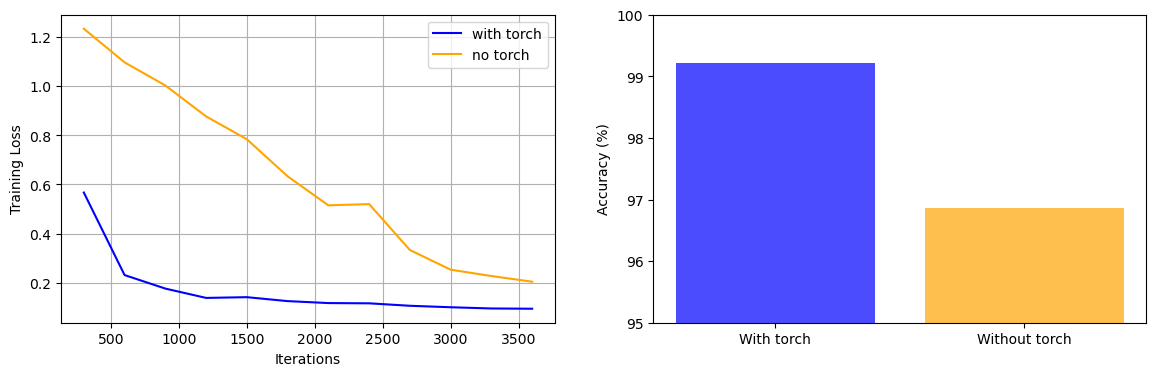

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
'''torch_output=    [epoch=  1, iter=  300] loss: 0.567
                    [epoch=  1, iter=  600] loss: 0.231
                    [epoch=  1, iter=  900] loss: 0.176
                    [epoch=  1, iter= 1200] loss: 0.138
                    [epoch=  1, iter= 1500] loss: 0.141
                    [epoch=  1, iter= 1800] loss: 0.125
                    [epoch=  2, iter=  300] loss: 0.117
                    [epoch=  2, iter=  600] loss: 0.116
                    [epoch=  2, iter=  900] loss: 0.106
                    [epoch=  2, iter= 1200] loss: 0.100
                    [epoch=  2, iter= 1500] loss: 0.095
                    [epoch=  2, iter= 1800] loss: 0.094
                    
no_torch_output  =  [epoch=  1, iter=  300] loss: 1.234
                    [epoch=  1, iter=  600] loss: 1.097
                    [epoch=  1, iter=  900] loss: 1.003
                    [epoch=  1, iter= 1200] loss: 0.877
                    [epoch=  1, iter= 1500] loss: 0.784
                    [epoch=  1, iter= 1800] loss: 0.633
                    [epoch=  2, iter=  300] loss: 0.515
                    [epoch=  2, iter=  600] loss: 0.520
                    [epoch=  2, iter=  900] loss: 0.333
                    [epoch=  2, iter= 1200] loss: 0.253
                    [epoch=  2, iter= 1500] loss: 0.227
                    [epoch=  2, iter= 1800] loss: 0.204
                    '''
torch_losses = [0.567, 0.231, 0.176, 0.138, 0.141, 0.125, 0.117, 0.116, 0.106, 0.100, 0.095, 0.094]
no_torch_losses = [1.234, 1.097, 1.003, 0.877, 0.784, 0.633, 0.515, 0.520, 0.333, 0.253, 0.227, 0.204]
iterations = [300, 600, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300, 3600]
acc = [99.22, 96.87]
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(iterations, torch_losses, label = "with torch",color="blue")
plt.plot(iterations, no_torch_losses, label = "no torch", color = "orange")
plt.ylabel("Training Loss")
plt.xlabel("Iterations")
plt.legend()
plt.grid()
plt.subplot(122)
models = ["With torch", "Without torch"]
accuracies = [99.22, 96.87]
plt.bar(models, accuracies, color=['blue', 'orange'], alpha = 0.7)
plt.ylabel("Accuracy (%)")
plt.ylim(95, 100)